In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
import os
sns.set()

In [2]:
n_epochs = 3
batch_size = 120
learning_rate = 0.001
momentum = 0.5
log_interval = 10

torch.manual_seed(0)

In [3]:
transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                torchvision.transforms.Lambda(lambda x: x.flatten())])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./cifar10/', train=True, download=True, transform=transforms), 
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./cifar10/', train=False, download=True, transform=transforms), 
        batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
def setup_axis(ax, num_epochs, r, title, data_shape, weights=False):
    ax.set_xlim(0, num_epochs - 1)
    ax.set_ylim(r[0], r[1])
    ax.set_title(title)
    
    data = np.empty(data_shape)
    data[:] = np.nan
    
    return data, ax.plot(data, label=(None if not weights else [f'Layer {x}' for x in range(data.shape[1])]))

# def set_data(plot, means, stds):
#     for i, line in enumerate(plot):
#         print("jere")
#         line.set_ydata = means[,i]

In [60]:
def train(net, train_loader, num_epochs, test_loader=None):
    
    criterion = nn.CrossEntropyLoss()
    
    plt.close('all')
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    hfig = display(fig, display_id=True)
    
    weights, weights_plot = setup_axis(axes[0], num_epochs, (-0.1, 0.1), "Weights", (num_epochs, len(net.weights)))
    weight_stds = weights.copy()
    accuracies, accuracies_plot = setup_axis(axes[1], num_epochs, (0, 1.1), "Accuracy", (num_epochs))
    accuracies_stds = accuracies.copy()
    
    test_means = np.zeros(len(test_loader))
    
    with torch.no_grad():
    
        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            with tqdm(total=len(train_loader) + len(test_loader), leave=False, desc="Batch") as pbar:
                running_loss = 0
                for batch_idx, (data, targets) in enumerate(train_loader):

                    y = net(data)

                    one_hot = nn.functional.one_hot(targets, num_classes=10)
                    
                    net.update(data, y - one_hot)

                    if torch.isnan(criterion(y, targets)):
                        print("Error: weights diverged")
                        return

                    running_loss += criterion(y, targets) / data.shape[0]
                    pbar.update(1)

                weights[epoch] = [torch.mean(w) for w in net.weights]
                weight_stds[epoch] = [torch.std(w) for w in net.weights]

                for batch_idx, (data, targets) in enumerate(test_loader):
                    test_means[batch_idx] = torch.mean((targets == np.argmax(net(data), axis=1)).float())
                    pbar.update(1)

                accuracies[epoch] = np.mean(test_means)
                
                for i, line in enumerate(weights_plot):
                    line.set_ydata(weights[:,i])
                accuracies_plot[0].set_ydata(accuracies)
                
                # set_data(weights_plot, weights, weight_stds)
                # set_data(accuracies_plot, accuracies, accuracies_stds)
                fig.canvas.draw()
                hfig.update(fig)

In [61]:
def generate_layer(in_size, out_size):
    w = nn.Linear(in_size, out_size, bias=False)
    a = nn.ReLU()
    
    return nn.Sequential(w, a)

def collect_activations(model, l):
    def hook(self, input, output):
        model.activations[l] = output.detach()
    return hook

def generate_B(n_in, B_mean_zero=True, Bstd=0.05):
    
    n_out = 10
    sd = np.sqrt(6 / n_in)
    if B_mean_zero:
        B = (torch.rand(n_in, n_out) * 2 * sd - sd) * Bstd  # mean zero
    else:
        B = (torch.rand(n_in, n_out) * sd) * Bstd
        
    return B

class FCNet(nn.Module):
    def __init__(self, layer_sizes, B_mean_zero=True, Bstd=0.05, output_dim=None):
        super(FCNet, self).__init__()
        self.layers_list = [nn.Sequential(nn.Linear(in_size, out_size, bias=False), nn.ReLU()) for in_size, out_size in zip(layer_sizes, layer_sizes[1:])]

        self.layers = nn.Sequential(*self.layers_list)
        
        self.weights = [layer[0].weight for layer in self.layers]
        
        self.activations = [None] * len(self.layers)
        
        for l, layer in enumerate(self.layers):
            layer.register_forward_hook(collect_activations(self, l))
            
        self.B = generate_B(layer_sizes[0], B_mean_zero=True, Bstd=0.05)
        
            
    def forward(self, x):
        return self.layers(x)
    
    def update(self, x, e, first_block=True, last_block=True):
        
        if first_block:
            hl_err = x + (e @ self.B.T)
        else:
            hl_err = x
        
        forward_activations = self.activations
        modulated_forward = self.forward(hl_err)
        modulated_activations = self.activations
        
        for l, layer in enumerate(self.layers):
            if (l == len(self.layers) - 1) and last_block:
                dwl = e.T @ (modulated_activations[l - 1] if l != 0 else x)
            else:
                dwl = (forward_activations[l] - modulated_activations[l]).T @ (modulated_activations[l - 1] if l != 0 else x)
            layer[0].weight -= learning_rate * dwl / batch_size
            
        return modulated_forward
            
                   
class FCRes_Net(nn.Module):
    def __init__(self, input_size, output_size, block_sizes, block_depth=3, B_mean_zero=True, Bstd=0.05):
        super(FCRes_Net, self).__init__()
        
        self.blocks = [FCNet([block] * (block_depth + 1), output_dim=10) for block in block_sizes]
        self.dim_maps = [FCNet([input_size, block_sizes[0]])]
        self.dim_maps += ([FCNet([in_size, out_size]) for in_size, out_size in zip(block_sizes, block_sizes[1:])])
        self.dim_maps.append(FCNet([block_sizes[-1], output_size]))
        self.weights = []
        for block in self.blocks: #TODO does not account for dim map weights
            self.weights += block.weights
        
    def __repr__(self):
        res = ''
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            res += f'Dim Map {b}\n'
            res += dim_map.__repr__()
            res += '\n'
            res += f'Block {b}\n'
            res += block.__repr__() + '\n'
        res += self.dim_maps[-1].__repr__()
        return res
    
    def forward(self, x, last_block=False):
        
        in_x = x
        x = 0
        
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            in_x = dim_map(in_x + x)
            x = block(in_x)
            
        return self.dim_maps[-1](x)
    
    def update(self, x, e):
        
        in_hl_err = x + (e @ self.dim_maps[0].B.T)
        hl_err = 0
        
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            in_hl_err = dim_map.update(in_hl_err + hl_err, e, True, False)
            hl_err = block.update(in_hl_err, e, False, False)
            
        self.dim_maps[-1].update(hl_err, e, False, True)

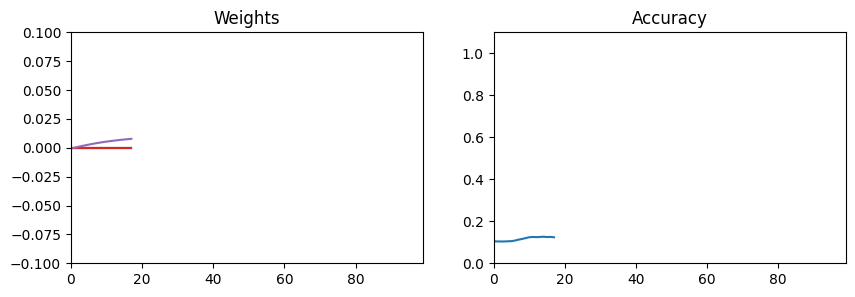

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
# net = FCRes_Net(32 * 32 * 3, 10, [1024])
net = FCNet([32 * 32 * 3, 1024, 512, 256, 128, 10])
train(net, train_loader, 100, test_loader)

In [ ]:
train(net, train_loader, 100, test_loader)

In [ ]:
net.layers

In [ ]:
save_dir = '/Users/avicooper/Documents/Yale/S2022/CPSC 490/FA and DFA/figures/fig6/'
os.makedirs(save_dir, exist_ok=True)
net = FCRes_Net(32 * 32 * 3, 10, [1024, 500, 300, 100])
train(net, train_loader, 10, test_loader)
plt.savefig(save_dir + "fig2.png")

In [ ]:
print(net)

In [ ]:
print(net)

In [ ]:
net = FCRes_Net(32 * 32 * 3, 10, [1000, 700, 500, 300])
train(net, train_loader, 10, test_loader)

In [ ]:
@dataclass
class ConvData:
    in_c: int
    out_c: int
    k_sz: int
    stride: int

class CNNNet(nn.Module):
    def __init__(self, conv_data, fc_layer_sizes, B_mean_zero=True, Bstd=0.05, output_dim=None):
        super(CNNNet, self).__init__()
        
        self.layers_list = [nn.Sequential(nn.Conv2d(cd.in_c, cd.out_c, cd.k_sz, stride=cd.stride, bias=False), nn.Tanh()) for cd in conv_data]
        self.unfolds = [nn.Unfold(cd.k_sz, stride=cd.stride) for cd in conv_data]
        self.layers_list.append(nn.Flatten())
        self.layers_list += [nn.Sequential(nn.Linear(in_size, out_size, bias=False), nn.Tanh()) for in_size, out_size in zip(fc_layer_sizes, fc_layer_sizes[1:])]
        
        self.layers = nn.Sequential(*self.layers_list)
        
        self.activations = [None] * len(self.layers)
        
        for l, layer in enumerate(self.layers):
            layer.register_forward_hook(collect_activations(self, l))
            
        self.B = generate_B(784, B_mean_zero=True, Bstd=0.05)
        
            
    def forward(self, x):
        return self.layers(x)
    
    def update(self, x, e, first_block=True, last_block=True):
        
        if first_block:
            print(x.shape, e.shape, self.B.T.shape, (e @ self.B.T).shape)
            hl_err = x + (e @ self.B.T)
        else:
            hl_err = x
        
        forward_activations = self.activations
        modulated_forward = self.forward(hl_err)
        modulated_activations = self.activations
        
        for l, layer in enumerate(self.layers):
            if (l == len(self.layers) - 1) and last_block:
                dwl = e.T @ (modulated_activations[l - 1] if l != 0 else x)
            else:
                dwl = (forward_activations[l] - modulated_activations[l]).T @ (modulated_activations[l - 1] if l != 0 else x)
            layer[0].weight -= learning_rate * dwl / batch_size
            
        return modulated_forward

In [ ]:
net = CNNNet([ConvData(1, 16, 7, 4), ConvData(16, 4, 2, 1)], [100, 10])
x = torch.rand(120, 1, 28, 28)
net(x)

In [ ]:
net.layers[0][0].weight += 

In [ ]:
net.activations[0].reshape(120, 1, 16, 36).shape

In [ ]:
torch.mean(net.activations[0].reshape(120, 1, 16, 36) * net.unfolds[0](x).reshape(120, 49, 1, 36), axis=(0, 1, 3))

In [ ]:
net.unfolds[0](x).reshape(120, 49, 1, 36).shape

In [ ]:
torch.mean(net.activations[0].reshape(120, 16, 36)[:,:1,:] * net.unfolds[0](x))

In [ ]:
net = FCRes_Net(784, 10, [1000, 700, 500, 300])
net